# Caso #

La divulgación de noticias falsas sobre política a nivel nacional e internacional es una amenaza que puede impactar la gobernabilidad de países y la seguridad global. A nivel interno de un país puede generar polarización y manipulación de la opinión pública debilitando la confianza en instituciones democráticas. Esto puede llevar a influir en elecciones, justificar medidas impopulares entre otras consecuencias. A nivel internacional, estas noticias pueden generar tensiones diplomáticas, influir en decisiones de política exterior y ser usadas en campañas de desestabilización por parte de gobiernos o grupos específicos. Esta reflexión motivó a un grupo de académicos a recolectar y generar noticias con el fin de utilizar aprendizaje automático para facilitar la detección de noticias falsas.

In [18]:
!pip install contractions


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: C:\Users\volpi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
!pip install inflect
# Manejo de gráficas
!pip install scikit-plot


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: C:\Users\volpi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.
ydata-profiling 4.12.2 requires visions[type_image_path]<0.8.0,>=0.7.5, but you have visions 0.7.4 which is incompatible.

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: C:\Users\volpi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\volpi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\volpi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\volpi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install pandas-profiling

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.6.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.
ydata-profiling 4.12.2 requires visions[type_image_path]<0.8.0,>=0.7.5, but you have visions 0.7.4 which is incompatible.

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: C:\Users\volpi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Perfilamiento y entendimiento de datos #

In [137]:
datos = pd.read_csv('fake_news_test.csv', sep = ';', encoding = 'utf-8')
data = datos.copy()

In [138]:
data.sample(10)

,ID,Titulo,Descripcion,Fecha
227,ID,Carolina Bescansa encabezará la lista de Más P...,"Tras distanciarse de Pablo Mónica García, trat...",04/10/2019
45,ID,Unidas Podemos confirma su abstención ante el ...,"Equo, Galicia en Comú e IU trasladan al Jefe d...",16/09/2019
324,ID,¿'Land' o Wonderland?: la pieza en la que se i...,La Audiencia Nacional ha juzgado los supuestos...,22/10/2022
639,ID,Los imputados por 'Rodea el Congreso' cuestion...,En los primeros testimonios del juicio solo un...,27/11/2019
695,ID,La oposición del PP en Salamanca a Mañueco pid...,Una jueza obligó a que se convocase el congres...,16/02/2023
795,ID,El PNV activará la elección de candidatos ante...,El secretario del área Institucional de la eje...,01/12/2018
522,ID,El Gobierno estudia cómo actuar para que los F...,Fuentes del Ejecutivo han admitido que pretend...,21/04/2021
839,ID,El PP carga contra Sánchez por su anuncio de c...,"Ciudadanos, por su parte, califica de anomalía...",10/11/2022
391,ID,Hacienda concluye que Salvador Alba defraudó 8...,Un documento elaborado por la Oficina Nacional...,23/12/2019
121,ID,La mesa de coordinación entre Gobierno y Comun...,Solo han pasado cuatro días desde la comparece...,25/09/2020


## Entendimiento de datos ##

In [139]:
# Descripción
data['Conteo'] = [len(x) for x in data['Descripcion']]
data['Moda'] = [[max(set([len(x) for x in i.split(' ')]), key = [len(x) for x in i.split(' ')].count)][0] for i in data['Descripcion']]
data['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in data['Descripcion']]
data['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in data['Descripcion']]

In [140]:
data

,ID,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min
0,ID,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",30/10/2018,119,4,15,1
1,ID,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,15/03/2023,197,2,14,1
2,ID,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,01/07/2019,215,3,11,2
3,ID,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",16/03/2020,446,2,16,1
4,ID,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,13/09/2021,343,2,12,1
...,...,...,...,...,...,...,...,...
995,ID,Irene Montero: 'El feminismo es la única propu...,La portavoz de Unidos Podemos asegura que ha c...,21/02/2019,171,2,13,1
996,ID,Cospedal encargó a Villarejo espiar al hermano...,El comisario encarcelado relata en una de sus ...,05/11/2018,197,2,11,1
997,ID,El Esquerra Unida i Alternativa de Miquel Puey...,Los nacionalistas esperan aprovechar la debili...,26/04/2023,195,2,13,1
998,ID,Valls: 'PP y Ciudadanos deben apoyar de una fo...,Un partido liberal progresista como Cs no pued...,30/06/2019,193,2,11,1


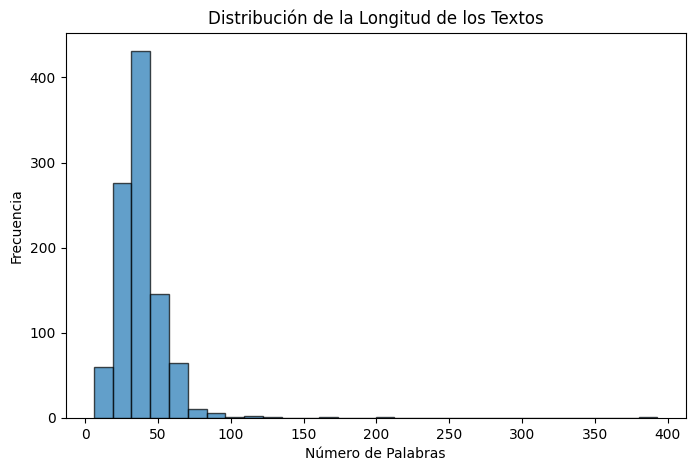

In [141]:
import matplotlib.pyplot as plt


data['text_length'] = data['Descripcion'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
plt.hist(data['text_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribución de la Longitud de los Textos')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.grid(False)
plt.show()


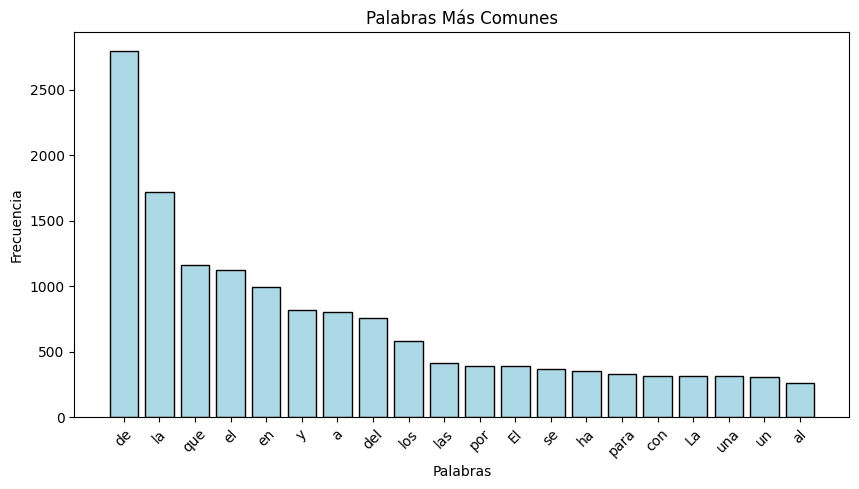

In [170]:
from collections import Counter

# Contar palabras
word_counts = Counter(data['Descripcion'].str.cat(sep=' ').split())

# Obtener las 20 palabras más comunes
common_words = word_counts.most_common(20)

# Separar palabras y frecuencias
words, counts = zip(*common_words)

plt.figure(figsize=(10,5))
plt.bar(words, counts, color='lightblue', edgecolor='black')
plt.xticks(rotation=45)
plt.title('Palabras Más Comunes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.grid(False)
plt.show()


## Preparación de datos ##

### Limpieza de datos ###

In [143]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = word.lower()
            new_words.append(new_word)
    return new_words
            
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   p = inflect.engine()
   print(words)
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = p.number_to_words(word)
           new_words.append(new_word)
           print("if " + new_word)
       else:
           new_words.append(word)
   return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    stop_words = set(stopwords.words('spanish'))

    for w in words:
        if w not in stop_words:
            new_words.append(w)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### Análisis Calidad de Datos ###

In [144]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1000 non-null   object
 1   Titulo       999 non-null    object
 2   Descripcion  1000 non-null   object
 3   Fecha        1000 non-null   object
 4   Conteo       1000 non-null   int64 
 5   Moda         1000 non-null   int64 
 6   Max          1000 non-null   int64 
 7   Min          1000 non-null   int64 
 8   text_length  1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


#### Nulos ####

In [145]:
 
nulo = data[data['Titulo'].isnull()]
nulo


,ID,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length
543,ID,NaN,#EnExpress ?????????\n#CirculaEnRedes ??\n??Pr...,25/01/2018,821,2,25,1,129


Se asignó un espaci vacío a la noticia que no tiene titulo

In [146]:
data['Titulo'] = data['Titulo'].fillna(' ')

#### Unicidad ####

In [147]:
duplicated_rows = data[data['Titulo'].duplicated()]
duplicated_rows

,ID,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length
535,ID,El gran temor de PP y Cs de cara al 4M: la mov...,El principal miedo que se ha instalado en el P...,22/04/2021,210,2,15,1,36
807,ID,La Junta Electoral multa con 1.000 euros a 'AB...,La Junta ha concluido que la entrevista a Carr...,05/04/2018,198,2,12,1,30


Se eliminaron las filas duplicadas

In [148]:
data = data.drop_duplicates(subset = 'Titulo', keep = 'first')

#### Validación Fechas ####

In [149]:
data['Fecha'] = pd.to_datetime(data['Fecha'], errors='coerce')

C:\Users\volpi\AppData\Local\Temp\ipykernel_16500\2529826816.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Fecha'] = pd.to_datetime(data['Fecha'], errors='coerce')
C:\Users\volpi\AppData\Local\Temp\ipykernel_16500\2529826816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fecha'] = pd.to_datetime(data['Fecha'], errors='coerce')


In [150]:
fechas_invalidas = data[data['Fecha'].isna()]
fechas_invalidas

,ID,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length


Todas las fechas son válidad

#### Datos Irrelevantes ####

In [151]:
data = data.drop(columns='ID')
data

,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length
0,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",2018-10-30,119,4,15,1,17
1,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,2023-03-15,197,2,14,1,34
2,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,2019-07-01,215,3,11,2,33
3,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",2020-03-16,446,2,16,1,71
4,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,2021-09-13,343,2,12,1,55
...,...,...,...,...,...,...,...,...
995,Irene Montero: 'El feminismo es la única propu...,La portavoz de Unidos Podemos asegura que ha c...,2019-02-21,171,2,13,1,28
996,Cospedal encargó a Villarejo espiar al hermano...,El comisario encarcelado relata en una de sus ...,2018-11-05,197,2,11,1,33
997,El Esquerra Unida i Alternativa de Miquel Puey...,Los nacionalistas esperan aprovechar la debili...,2023-04-26,195,2,13,1,33
998,Valls: 'PP y Ciudadanos deben apoyar de una fo...,Un partido liberal progresista como Cs no pued...,2019-06-30,193,2,11,1,34


### Tokenización ###

In [152]:
data['Descripcion'] = data['Descripcion'].apply(contractions.fix)
data['Titulo'] = data['Titulo'].apply(contractions.fix) 

In [153]:
data['Titulo'] = data['Titulo'].apply(contractions.fix) 

In [154]:
data['words_descripcion'] = data['Descripcion'].apply(word_tokenize)
data['words_titulo'] = data['Titulo'].apply(word_tokenize)
data.head()

,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo
0,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",2018-10-30,119,4,15,1,17,"[Portavoces, de, Ciudadanos, ,, PNV, ,, UPN, ,...","[La, mesa, del, congreso, censura, un, encuent..."
1,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,2023-03-15,197,2,14,1,34,"[No, es, la, primera, vez, que, los, ciudadano...","[La, brecha, digital, que, dificulta, el, acce..."
2,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,2019-07-01,215,3,11,2,33,"[El, partido, morado, reprocha, que, los, soci...","[PP, apremia, al, EQUO, a, presentar, una, pro..."
3,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",2020-03-16,446,2,16,1,71,"[La, renuncia, de, Felipe, VI, a, su, herencia...","[De, soberano, garante, de, la, democracia, a,..."
4,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,2021-09-13,343,2,12,1,55,"[El, Ejecutivo, también, prorrogará, la, suspe...","[El, Gobierno, aprobará, este, martes, detraer..."


In [155]:
data['words_descripcion'].dropna()
data['words_titulo'].dropna()

0      [La, mesa, del, congreso, censura, un, encuent...
1      [La, brecha, digital, que, dificulta, el, acce...
2      [PP, apremia, al, EQUO, a, presentar, una, pro...
3      [De, soberano, garante, de, la, democracia, a,...
4      [El, Gobierno, aprobará, este, martes, detraer...
                             ...                        
995    [Irene, Montero, :, 'El, feminismo, es, la, ún...
996    [Cospedal, encargó, a, Villarejo, espiar, al, ...
997    [El, Esquerra, Unida, i, Alternativa, de, Miqu...
998    [Valls, :, 'PP, y, Ciudadanos, deben, apoyar, ...
999    [Los, deportados, vascos, buscarán, volver, a,...
Name: words_titulo, Length: 998, dtype: object

In [156]:
none = data[data['words_descripcion'].isna()]
none

,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo


In [157]:
data['words_descripcion'].info()

<class 'pandas.core.series.Series'>
Index: 998 entries, 0 to 999
Series name: words_descripcion
Non-Null Count  Dtype 
--------------  ----- 
998 non-null    object
dtypes: object(1)
memory usage: 15.6+ KB


In [158]:
data['words_titulo'].info()

<class 'pandas.core.series.Series'>
Index: 998 entries, 0 to 999
Series name: words_titulo
Non-Null Count  Dtype 
--------------  ----- 
998 non-null    object
dtypes: object(1)
memory usage: 15.6+ KB


In [159]:
data['prep_descripcion'] = data['words_descripcion'].apply(preprocessing)
data['prep_titulo'] = data['words_titulo'].apply(preprocessing)

data.head()

['portavoces', 'de', 'ciudadanos', ',', 'pnv', ',', 'upn', ',', 'psoe', ',', 'unidos', 'pp', 'y', 'equo', 'denuncian', 'juntos', 'esta', 'censura', 'que', 'consideran', 'injustificable', '.']
['no', 'es', 'la', 'primera', 'vez', 'que', 'los', 'ciudadanos', 'vulnerables', 'se', 'topan', 'con', 'obstáculos', 'a', 'la', 'hora', 'de', 'solicitar', 'ayudas', 'debido', 'al', 'lenguaje', 'burocrático', ',', 'el', 'obligatoriedad', 'de', 'la', 'cl', '@', 've', 'pin', 'o', 'la', 'conexión', 'a', 'internet', '.']
['el', 'partido', 'morado', 'reprocha', 'que', 'los', 'socialistas', 'tengan', 'paralizado', 'el', 'congreso', ':', 'hay', '350', 'diputados', 'que', 'no', 'pueden', 'trabajar', 'porque', 'no', 'hay', 'actividad', '.', 'continúan', 'con', 'la', 'mano', 'tendida', 'para', 'iniciar', 'una', 'negociación', 'de', 'gobierno', '.']
if three hundred and fifty
['la', 'renuncia', 'de', 'felipe', 'vi', 'a', 'su', 'herencia', ',', 'procedente', 'de', 'las', 'multimillonarias', 'comisiones', 'embol

,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo,prep_descripcion,prep_titulo
0,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",2018-10-30,119,4,15,1,17,"[Portavoces, de, Ciudadanos, ,, PNV, ,, UPN, ,...","[La, mesa, del, congreso, censura, un, encuent...","[portavoces, ciudadanos, pnv, upn, psoe, unido...","[mesa, congreso, censura, encuentro, internaci..."
1,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,2023-03-15,197,2,14,1,34,"[No, es, la, primera, vez, que, los, ciudadano...","[La, brecha, digital, que, dificulta, el, acce...","[primera, vez, ciudadanos, vulnerables, topan,...","[brecha, digital, dificulta, acceso, ayudas, p..."
2,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,2019-07-01,215,3,11,2,33,"[El, partido, morado, reprocha, que, los, soci...","[PP, apremia, al, EQUO, a, presentar, una, pro...","[partido, morado, reprocha, socialistas, paral...","[pp, apremia, equo, presentar, propuesta, gobi..."
3,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",2020-03-16,446,2,16,1,71,"[La, renuncia, de, Felipe, VI, a, su, herencia...","[De, soberano, garante, de, la, democracia, a,...","[renuncia, felipe, vi, herencia, procedente, m...","[soberano, garante, democracia, rey, corrupto,..."
4,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,2021-09-13,343,2,12,1,55,"[El, Ejecutivo, también, prorrogará, la, suspe...","[El, Gobierno, aprobará, este, martes, detraer...","[ejecutivo, tambien, prorrogara, suspension, i...","[gobierno, aprobara, martes, detraer, benefici..."


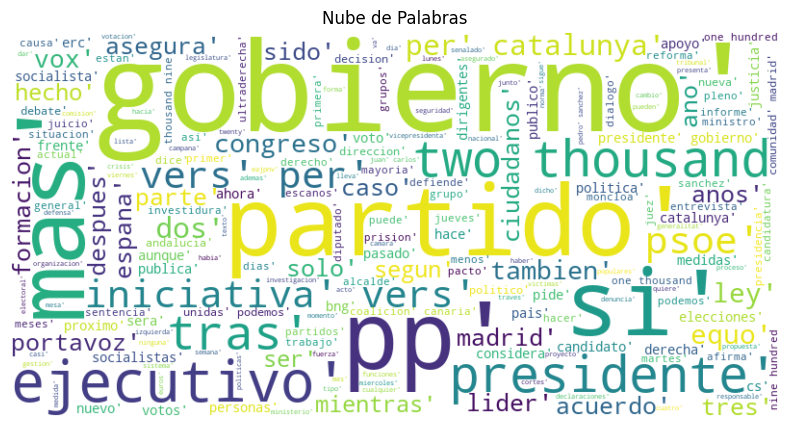

In [160]:
from wordcloud import WordCloud


all_text = " ".join(str(t) for t in data['prep_descripcion'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras')
plt.show()


### Normalización ###

In [161]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
   stems = stem_words(words)
   lemmas = lemmatize_verbs(words)
   return stems + lemmas


data['prep_descripcion'] = data['prep_descripcion'].apply(stem_and_lemmatize) 
data['prep_titulo'] = data['prep_titulo'].apply(stem_and_lemmatize)
data.head()

,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo,prep_descripcion,prep_titulo
0,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",2018-10-30,119,4,15,1,17,"[Portavoces, de, Ciudadanos, ,, PNV, ,, UPN, ,...","[La, mesa, del, congreso, censura, un, encuent...","[portavoc, ciudadano, pnv, upn, pso, unido, pp...","[mes, congreso, censur, encuentro, internac, p..."
1,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,2023-03-15,197,2,14,1,34,"[No, es, la, primera, vez, que, los, ciudadano...","[La, brecha, digital, que, dificulta, el, acce...","[primer, vez, ciudadano, vuln, top, obstaculo,...","[brech, digit, dificult, acceso, ayuda, person..."
2,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,2019-07-01,215,3,11,2,33,"[El, partido, morado, reprocha, que, los, soci...","[PP, apremia, al, EQUO, a, presentar, una, pro...","[partido, morado, reproch, socialista, paraliz...","[pp, aprem, equo, present, propuest, gobierno,..."
3,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",2020-03-16,446,2,16,1,71,"[La, renuncia, de, Felipe, VI, a, su, herencia...","[De, soberano, garante, de, la, democracia, a,...","[renunc, felip, vi, herenc, proc, multimillona...","[soberano, gar, democrac, rey, corrupto, apart..."
4,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,2021-09-13,343,2,12,1,55,"[El, Ejecutivo, también, prorrogará, la, suspe...","[El, Gobierno, aprobará, este, martes, detraer...","[ejecutivo, tamby, prorrogar, suspend, impuest...","[gobierno, aprobar, mart, detra, beneficio, ex..."


### Selección de campos ###

In [162]:
data['prep_descripcion'] = data['prep_descripcion'].apply(lambda x: ' '.join(map(str, x)))
data['prep_titulo'] = data['prep_titulo'].apply(lambda x: ' '.join(map(str, x)))
data

,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min,text_length,words_descripcion,words_titulo,prep_descripcion,prep_titulo
0,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",2018-10-30,119,4,15,1,17,"[Portavoces, de, Ciudadanos, ,, PNV, ,, UPN, ,...","[La, mesa, del, congreso, censura, un, encuent...",portavoc ciudadano pnv upn pso unido pp equo d...,mes congreso censur encuentro internac parlame...
1,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,2023-03-15,197,2,14,1,34,"[No, es, la, primera, vez, que, los, ciudadano...","[La, brecha, digital, que, dificulta, el, acce...",primer vez ciudadano vuln top obstaculo hor so...,brech digit dificult acceso ayuda persona vuln...
2,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,2019-07-01,215,3,11,2,33,"[El, partido, morado, reprocha, que, los, soci...","[PP, apremia, al, EQUO, a, presentar, una, pro...",partido morado reproch socialista paralizado c...,pp aprem equo present propuest gobierno critic...
3,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",2020-03-16,446,2,16,1,71,"[La, renuncia, de, Felipe, VI, a, su, herencia...","[De, soberano, garante, de, la, democracia, a,...",renunc felip vi herenc proc multimillonaria co...,soberano gar democrac rey corrupto apartado de...
4,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,2021-09-13,343,2,12,1,55,"[El, Ejecutivo, también, prorrogará, la, suspe...","[El, Gobierno, aprobará, este, martes, detraer...",ejecutivo tamby prorrogar suspend impuesto gen...,gobierno aprobar mart detra beneficio extraord...
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Irene Montero: 'El feminismo es la única propu...,La portavoz de Unidos Podemos asegura que ha c...,2019-02-21,171,2,13,1,28,"[La, portavoz, de, Unidos, Podemos, asegura, q...","[Irene, Montero, :, 'El, feminismo, es, la, ún...",portavoz unido podemo asegur comenzado precamp...,ir montero feminismo unic propuest ganador fre...
996,Cospedal encargó a Villarejo espiar al hermano...,El comisario encarcelado relata en una de sus ...,2018-11-05,197,2,11,1,33,"[El, comisario, encarcelado, relata, en, una, ...","[Cospedal, encargó, a, Villarejo, espiar, al, ...",comisario encarcelado relat grabac exnumero do...,cosp encargo villarejo espi hermano rubalcab s...
997,El Esquerra Unida i Alternativa de Miquel Puey...,Los nacionalistas esperan aprovechar la debili...,2023-04-26,195,2,13,1,33,"[Los, nacionalistas, esperan, aprovechar, la, ...","[El, Esquerra, Unida, i, Alternativa, de, Miqu...",nacionalista esp aprovech debilidad nuev canar...,esquerr unid i alternativ miquel pueyo usar mu...
998,Valls: 'PP y Ciudadanos deben apoyar de una fo...,Un partido liberal progresista como Cs no pued...,2019-06-30,193,2,11,1,34,"[Un, partido, liberal, progresista, como, Cs, ...","[Valls, :, 'PP, y, Ciudadanos, deben, apoyar, ...",partido lib progresist cs pued pact vox ensuc ...,val pp ciudadano deb apoy form you gobierno va...
